<a href="https://colab.research.google.com/github/Ekaagra08/News-Recommendation-system/blob/main/LDA_based_Recomendation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Importing modules
import pandas as pd
import os
import re

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

# Visualize the topics
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
#run just once
! pip install -q kaggle
from google.colab import files 
files.upload() 
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18536  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11197  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5744  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21

In [ ]:
!kaggle datasets download -d shivamb/netflix-shows

  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 22.2MB/s]


In [ ]:
!unzip netflix-shows.zip

Archive:  netflix-shows.zip
  inflating: netflix_titles.csv      


In [ ]:
df = pd.read_csv("/content/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
# remove non-english words. Reference: https://datascience.stackexchange.com/questions/46705/to-remove-chinese-characters-as-features
df['description'] = df['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(df['description']))

# print(data_words)

In [ ]:
stop_words = stopwords.words('english')
# stop_words.extend(['']) #extend existing stop word list if needed
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [ ]:
# Build the bigram 
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

In [ ]:
# spotted bigrams such as high_school, civil_war, martial_arts
print(data_words_bigrams)

[['father', 'nears', 'end', 'life', 'filmmaker', 'kirsten', 'johnson', 'stages', 'death', 'inventive', 'comical', 'ways', 'help', 'face', 'inevitable'], ['crossing', 'paths', 'party', 'cape', 'town', 'teen', 'sets', 'prove', 'whether', 'private_school', 'swimming', 'star', 'sister', 'abducted', 'birth'], ['protect', 'family', 'powerful_drug', 'lord', 'skilled', 'thief', 'mehdi', 'expert', 'team', 'robbers', 'pulled', 'violent', 'deadly', 'turf', 'war'], ['feuds', 'flirtations', 'toilet', 'talk', 'go', 'among', 'incarcerated', 'women', 'orleans', 'justice', 'center', 'new_orleans', 'gritty', 'reality_series'], ['city', 'coaching', 'centers', 'known', 'train', 'indias', 'finest', 'collegiate', 'minds', 'earnest', 'unexceptional', 'student', 'friends', 'navigate', 'campus', 'life'], ['arrival', 'charismatic', 'young', 'priest', 'brings', 'glorious', 'miracles', 'ominous', 'mysteries', 'renewed', 'religious', 'fervor', 'dying', 'town', 'desperate', 'believe'], ['equestria', 'divided', 'bri

2.2 EDA

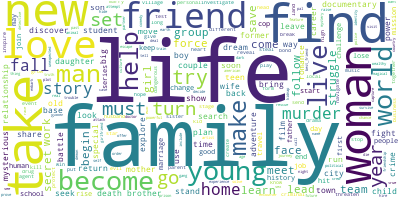

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])
# print(id2word[:10])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(8, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(18, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(13, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)], [(77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)], [(3, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1)], [(8, 1), (38, 1), (103, 1),

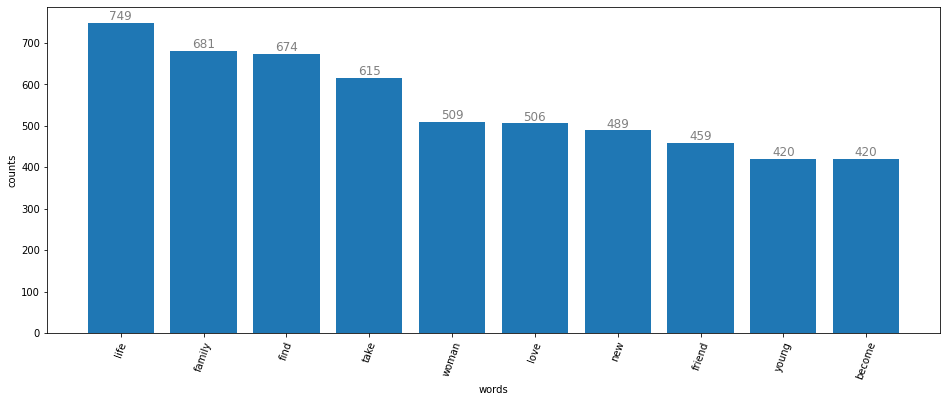

In [ ]:
import operator


word_freq = []
word_list = []
count_dict = {}
for n in id2word.values():
    count_dict[n] = list_of_words.count(n)
sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)[0:10]

plt.figure(figsize=(16,6))
plt.bar(range(len(sorted_dict)), [val[1] for val in sorted_dict], align='center')
plt.xticks(range(len(sorted_dict)), [val[0] for val in sorted_dict])
plt.xticks(rotation=70)
plt.xlabel('words')
plt.ylabel('counts')

# setting data labels
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='grey', ha='center', va='bottom')
    
plt.show()


2.3 Hyperparameter Tuning for LDA 

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"world" + 0.023*"survive" + 0.022*"face" + 0.020*"mind" + '
  '0.020*"reporter" + 0.018*"spooky" + 0.017*"drag" + 0.017*"tycoon" + '
  '0.016*"dysfunctional_family" + 0.016*"new"'),
 (1,
  '0.033*"child" + 0.029*"zombie" + 0.029*"take" + 0.022*"love" + 0.021*"grow" '
  '+ 0.019*"class" + 0.018*"root" + 0.016*"mother" + 0.015*"subject" + '
  '0.014*"search"'),
 (2,
  '0.024*"must" + 0.022*"political" + 0.016*"family" + 0.015*"kill" + '
  '0.014*"villain" + 0.014*"psychotic" + 0.014*"brother" + 0.013*"crop" + '
  '0.013*"daughter" + 0.013*"strong_willed"'),
 (3,
  '0.029*"boy" + 0.018*"game" + 0.018*"truth" + 0.017*"town" + 0.016*"take" + '
  '0.016*"live" + 0.014*"poor" + 0.014*"life" + 0.014*"middle" + '
  '0.014*"diverse"'),
 (4,
  '0.024*"way" + 0.019*"befriend" + 0.018*"music" + 0.018*"sister" + '
  '0.018*"history" + 0.015*"love" + 0.012*"face" + 0.012*"fall" + '
  '0.012*"village" + 0.011*"new"'),
 (5,
  '0.034*"former" + 0.020*"attack" + 0.017*"find" + 0.015*"may" +

In [ ]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3686873754438307


In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [0,5,10,15,20,25,30,35,40]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

,topic_param,coherence_score
0,0,0.379946
1,5,0.388183
2,10,0.376031
3,15,0.367893
4,20,0.363764
5,25,0.374249
6,30,0.394469
7,35,0.366988
8,40,0.383219


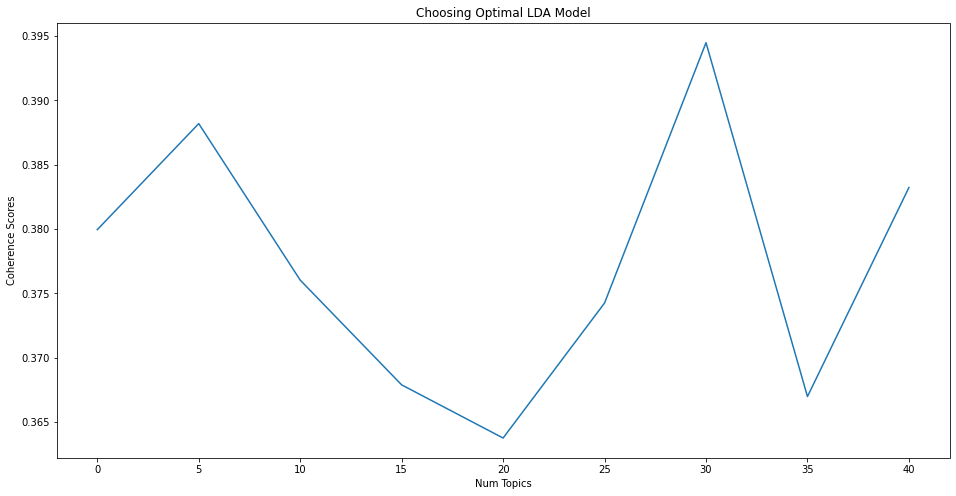

In [ ]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()



#### 2.4 Final LDA Model

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"death" + 0.019*"wife" + 0.015*"seek" + 0.014*"father" + 0.014*"join" '
  '+ 0.010*"decide" + 0.009*"parent" + 0.009*"hire" + 0.007*"well" + '
  '0.006*"wedding"'),
 (1,
  '0.025*"game" + 0.017*"poor" + 0.012*"send" + 0.012*"long" + '
  '0.010*"dysfunctional_family" + 0.010*"steal" + 0.010*"drug" + 0.009*"agent" '
  '+ 0.008*"player" + 0.008*"notorious"'),
 (2,
  '0.029*"political" + 0.021*"kill" + 0.015*"change" + 0.013*"hit" + '
  '0.011*"terrorist" + 0.011*"american" + 0.007*"wealthy" + 0.007*"action" + '
  '0.006*"target" + 0.005*"activist"'),
 (3,
  '0.023*"history" + 0.019*"villain" + 0.017*"superhero" + 0.017*"city" + '
  '0.015*"crop" + 0.011*"include" + 0.009*"youthful" + 0.008*"late" + '
  '0.008*"call" + 0.008*"savior"'),
 (4,
  '0.016*"take" + 0.014*"life" + 0.014*"find" + 0.013*"new" + 0.012*"family" + '
  '0.010*"love" + 0.009*"woman" + 0.009*"young" + 0.009*"become" + '
  '0.008*"live"'),
 (5,
  '0.035*"way" + 0.025*"world" + 0.019*"return" + 0.019*"bring" 

In [ ]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [ ]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df['Doc'] = doc_num
df['Topic'] = topic_num
df['Probability'] = prob
df.to_csv("doc_topic_matrix.csv", index=False)

#### 2.5 Visualize Topics

In [ ]:
!pip install gensim

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.027617  0.004504       1        1   2.860933
1     -0.031864 -0.005814       2        1   2.908949
2     -0.031344  0.003355       3        1   2.236049
3     -0.028431  0.008112       4        1   1.540350
4      0.264351 -0.017152       5        1  46.862284
5     -0.031188  0.026747       6        1   3.137359
6     -0.026395  0.018072       7        1   2.960665
7     -0.023797  0.006283       8        1   1.900604
8     -0.025266  0.005704       9        1   1.551228
9     -0.026465  0.007543      10        1   1.939637
10    -0.020975  0.004130      11        1   3.325705
11     0.036350  0.070534      12        1  13.122888
12    -0.026387  0.007217      13        1   2.158987
13    -0.021153 -0.172655      14        1   5.725410
14     0.020181  0.033421      15        1   7.768955, topic_info=            Term        Freq       Total Category  logprob  loglift
168        world  214.000000  214.000000  Default  30.0000  30.0000
11           way  103.000000  103.000000  Default  29.0000  29.0000
808  documentary  175.000000  175.000000  Default  28.0000  28.0000
513         work   75.000000   75.000000  Default  27.0000  27.0000
8           life  691.000000  691.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
182        learn   33.424831  172.389626  Topic15  -5.3079   0.9146
323         evil   21.639725   63.840347  Topic15  -5.7427   1.4732
5           help   32.423985  229.211019  Topic15  -5.3383   0.5993
208         land   20.838745   75.031278  Topic15  -5.7804   1.2739
45        friend   23.507721  265.735142  Topic15  -5.6599   0.1299

[621 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1300      1  0.090798   abandon
1300      5  0.756648   abandon
1300      7  0.030266   abandon
1300     11  0.030266   abandon
1300     12  0.030266   abandon
...     ...       ...       ...
5740     12  0.020856  youthful
5740     15  0.020856  youthful
2451      5  0.915300    zombie
2451     12  0.004238    zombie
2451     15  0.063563    zombie

[2513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

#### 2.6  Top 10 recommended tv shows/movies based on topic modelling

In [ ]:
def recommend_by_storyline(title, df):
    recommended = []
    top10_list = []
    
    title = title.lower()
    df['title'] = df['title'].str.lower()
    topic_num = df[df['title']==title].Topic.values
    doc_num = df[df['title']==title].Doc.values    
    
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['title'] = output_df['title'].str.title()
    
    for each in top10_list:
        recommended.append(output_df.iloc[each].title)
        
    return recommended


In [ ]:
recommend_by_storyline("Avengers: Infinity War", df)

['Heroes Wanted',
 'Wolf',
 'Wild Wild West',
 'Sarkar',
 'A Storybots Space Adventure',
 'The Yin Yang Master',
 'Terminator Salvation',
 'The Binding',
 'Countdown: Inspiration4 Mission To Space',
 'Event Horizon']

In [ ]:
recommend_by_storyline("Naruto Shippuden : Blood Prison", df)

['What Did Jack Do?',
 'Zinzana',
 'Against The Tide',
 'Reaction',
 '60 Days In',
 'Naruto Shippuden The Movie: Blood Prison',
 'Interrogation',
 'The Adjusters',
 'Chal Bhaag',
 'Survivors Guide To Prison']